## Machine Learning

In [59]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np
from tqdm import tqdm
# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data.
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries to help with model building
from xgboost import XGBClassifier as xgb
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import RidgeClassifier,LassoCV,RidgeClassifierCV
from sklearn.metrics import mean_squared_error, make_scorer,mean_squared_log_error
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#for deep Learning
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [60]:
import pandas as pd
data=pd.read_csv('train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [20]:
data.loc[[1]]

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...


In [21]:
data['comment'][1]

'You do know west teams play against west teams more than east teams right?'

In [22]:
data['parent_comment'][1]

'The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.'

In [23]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [24]:
data.shape

(1010826, 10)

In [62]:
data['comment']=data['comment'].fillna('No Comment')

In [63]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [64]:
def decontractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [65]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Shreyas
[nltk_data]     Khot\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [66]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [30]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|█████████████████████████████████████████████████████████████████████| 1010826/1010826 [00:20<00:00, 50103.20it/s]


In [31]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|█████████████████████████████████████████████████████████████████████| 1010826/1010826 [00:27<00:00, 36802.56it/s]


In [32]:
data.shape

(1010826, 10)

In [33]:
data.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [34]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to C:\Users\Shreyas
[nltk_data]     Khot\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Polarity Score

In [35]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [36]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████████████████████████████████████████████████████████████████| 1010826/1010826 [03:33<00:00, 4742.71it/s]


In [37]:
data.shape

(1010826, 14)

In [38]:
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [39]:
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

In [ ]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec1 = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_comment = vec1.fit_transform(X_train['comment'])
X_test_comment = vec1.transform(X_test['comment'])

CPU times: total: 33.2 s
Wall time: 34.4 s


In [ ]:
print(X_train_comment.shape)

(707578, 200000)


In [ ]:
%%time
vec2 = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_parent = vec2.fit_transform(X_train['parent_comment'])
X_test_parent = vec2.transform(X_test['parent_comment'])

CPU times: total: 1min 23s
Wall time: 1min 24s


In [ ]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_author1 = vec = tfidf_desc = TfidfVectorizer()
X_train_author = lb_brand_author1.fit_transform(X_train['author'])
X_test_author = lb_brand_author1.transform(X_test['author'])

CPU times: total: 3.73 s
Wall time: 3.95 s


In [ ]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_author2 = vec = tfidf_desc = TfidfVectorizer()
lb_brand_subreddit = LabelBinarizer(sparse_output=True)
X_train_subreddit = lb_brand_author2.fit_transform(X_train['subreddit'])
X_test_subreddit = lb_brand_author2.transform(X_test['subreddit'])

CPU times: total: 2.38 s
Wall time: 2.38 s


In [ ]:
import pickle
filename1 = 'tf1.pkl'
pickle.dump(vec1, open(filename1, 'wb'))
filename2 = 'tf2.pkl'
pickle.dump(vec2, open(filename2, 'wb'))
filename1 = 'tf3.pkl'
pickle.dump(lb_brand_author1, open(filename1, 'wb'))
filename2 = 'tf4.pkl'
pickle.dump(lb_brand_author2, open(filename2, 'wb'))

In [ ]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 46.6 ms


In [ ]:
%%time
trans = Normalizer()
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 17.9 ms


In [ ]:
%%time
trans = Normalizer()
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 31.3 ms


In [ ]:
%%time
trans = Normalizer()
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))

CPU times: total: 31.2 ms
Wall time: 31.1 ms


In [ ]:
%%time
trans = Normalizer()
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))

CPU times: total: 31.2 ms
Wall time: 45.5 ms


In [ ]:
%%time
trans = Normalizer()
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))

CPU times: total: 31.2 ms
Wall time: 46.6 ms


In [ ]:
%%time
trans = Normalizer()
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 31.5 ms


In [ ]:
%%time
trans = Normalizer()
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 15.4 ms


In [ ]:
%%time
trans = Normalizer()
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

CPU times: total: 0 ns
Wall time: 15.7 ms


In [ ]:
%%time
from scipy.sparse import hstack
X_train=hstack((X_train_comment,X_train_parent,X_train_author,X_train_subreddit,X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_com_len,X_train_parent_com_len)).tocsr().astype('float32')
X_test=hstack((X_test_comment,X_test_parent,X_test_author,X_test_subreddit,X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neg,X_test_pos,X_test_neu,X_test_com_len,X_test_parent_com_len)).tocsr().astype('float32')

CPU times: total: 1.86 s
Wall time: 1.95 s


In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(707578, 654811) (707578,)
(303248, 654811) (303248,)


In [ ]:
def get_metrics_score(model,train,test,train_y,test_y,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(train)
    pred_test = model.predict(test)
    
    train_acc = model.score(train,train_y)
    test_acc = model.score(test,test_y)
    
    train_recall = metrics.recall_score(train_y,pred_train)
    test_recall = metrics.recall_score(test_y,pred_test)
    
    train_precision = metrics.precision_score(train_y,pred_train)
    test_precision = metrics.precision_score(test_y,pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(train,train_y))
        print("Accuracy on test set : ",model.score(test,test_y))
        print("Recall on training set : ",metrics.recall_score(train_y,pred_train))
        print("Recall on test set : ",metrics.recall_score(test_y,pred_test))
        print("Precision on training set : ",metrics.precision_score(train_y,pred_train))
        print("Precision on test set : ",metrics.precision_score(test_y,pred_test))
        print("log_loss on training set : ",metrics.log_loss(train_y,pred_train))
        print("log_loss on test set : ",metrics.log_loss(test_y,pred_test))
    return score_list # returning the list with train and test scores

In [ ]:
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:


models = []  # Empty list to store all the models

# Appending pipelines for each model into the list

models.append(("logistic",Pipeline(steps=[("logistic", LogisticRegression(random_state=1,n_jobs=-1)),]),))
models.append(("XGB",Pipeline(steps=[("XGB", xgb(random_state=1)),]),))
#models.append(("naive_bayes",Pipeline(steps=[("naive_bayes", MultinomialNB()),]),))
models.append(("SGD",Pipeline(steps=[("SGD", SGDClassifier(random_state=1)),]),))
print(models)

[('logistic', Pipeline(steps=[('logistic', LogisticRegression(n_jobs=-1, random_state=1))])), ('XGB', Pipeline(steps=[('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               gamma=None, gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators

In [ ]:
results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in tqdm(models):
    # Setting number of splits equal to 5
    scores = cross_val_score(model,X_train,y_train, cv=5,
                             scoring='accuracy')
    results.append(scores)
    names.append(name)
    print("{}: {}".format(name, scores.mean() * 100))

 33%|███████████████████████████▋                                                       | 1/3 [02:42<05:25, 162.80s/it]

logistic: 67.41758470424027


 67%|███████████████████████████████████████████████████████▎                           | 2/3 [14:09<07:50, 470.96s/it]

XGB: 65.53821657924574


100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [14:26<00:00, 288.91s/it]

SGD: 66.1887439268547


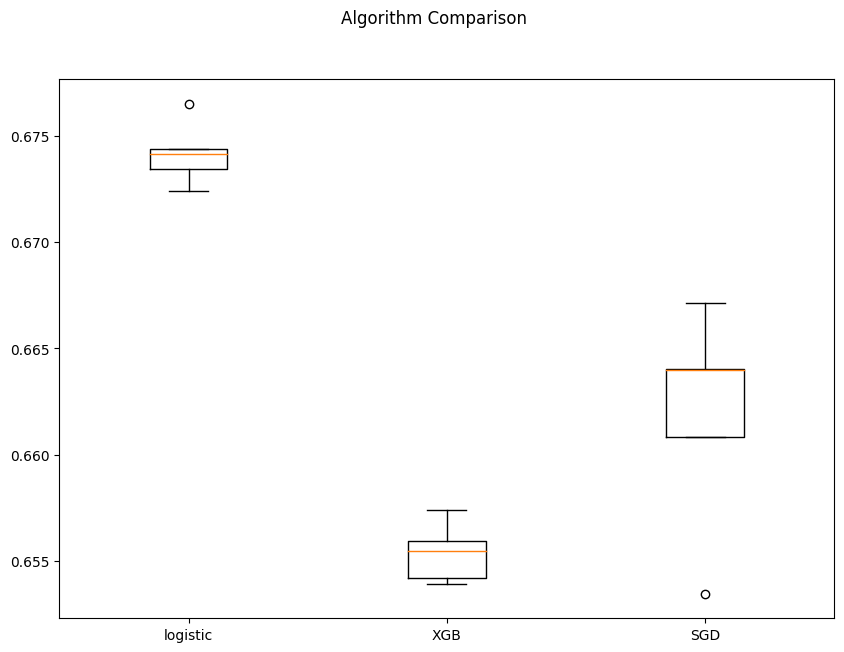

In [ ]:
fig = plt.figure(figsize=(10, 7))

fig.suptitle("Algorithm Comparison")




ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

**Logistic Regression(RandomizedSearchCV)**

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV
  
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}
  
logreg = LogisticRegression()
  
logreg_cv = RandomizedSearchCV(logreg, param_grid, cv = 5)
  
logreg_cv.fit(X_train, y_train)
  
# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 0.4393970560760795}
Best score is 0.6751863374438978
CPU times: total: 20min 55s
Wall time: 18min 22s


In [ ]:
model= LogisticRegression(C=0.4393970560760795)
model.fit(train_s,y_train)

LogisticRegression(C=0.4393970560760795)

Accuracy on training set :  0.7075092781290543
Accuracy on test set :  0.6779929298791748
Recall on training set :  0.6735709702675888
Recall on test set :  0.6435458766422202
Precision on training set :  0.7226199681601092
Precision on test set :  0.6911629290682684
log_loss on training set :  10.102375009209512
log_loss on test set :  11.121845158608771


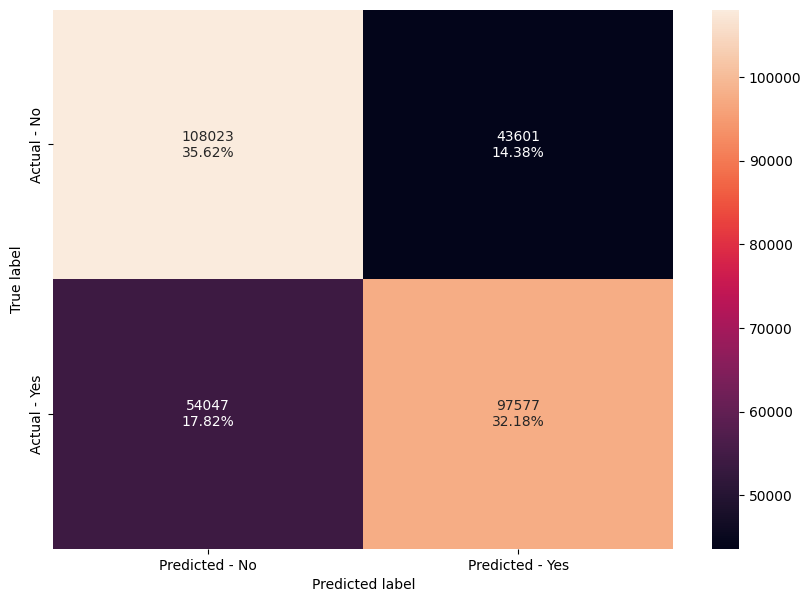

In [ ]:
get_metrics_score(model,X_train,X_test,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(model, y_test)

**XGBClassifier**

In [ ]:
%%time
params = {'max_depth': [2,4,8,10, 12],
              'learning_rate': [0.03, 0.10,0.25], 
              'n_estimators': [100, 500, 1000], 
          }
model_xgb= xgb(colsample_bytree=0.8)

model=RandomizedSearchCV(model_xgb, params,
                                    return_train_score=True, scoring = 'accuracy',
                                    cv = 3,verbose=10)
model.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START learning_rate=0.1, max_depth=12, n_estimators=100..........
[CV 1/3; 1/10] END learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.666, test=0.647) total time= 3.1min
[CV 2/3; 1/10] START learning_rate=0.1, max_depth=12, n_estimators=100..........
[CV 2/3; 1/10] END learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.665, test=0.649) total time= 3.1min
[CV 3/3; 1/10] START learning_rate=0.1, max_depth=12, n_estimators=100..........
[CV 3/3; 1/10] END learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.665, test=0.650) total time= 3.6min
[CV 1/3; 2/10] START learning_rate=0.1, max_depth=2, n_estimators=500...........
[CV 1/3; 2/10] END learning_rate=0.1, max_depth=2, n_estimators=500;, score=(train=0.645, test=0.640) total time= 3.6min
[CV 2/3; 2/10] START learning_rate=0.1, max_depth=2, n_estimators=500...........
[CV 2/3; 2/10] END learning_rate=0.1, max_depth

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=0.8,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           m...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   param_distributions={'learning_rate': [0.03, 0.1, 0.25],
                                        'max_depth': [2, 4, 8, 10, 12],
                                        'n_estimators': [100, 500, 1000]},
                   return_train_score=True, scoring='accuracy', verbose=10)

In [ ]:
model.best_params_

{'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.25}

In [ ]:
%%time
xgb_model = xgb(n_estimators=1000, learning_rate=0.25,max_depth=10,
               colsample_bytree=0.8, n_jobs=-1)

xgb_model.fit(X_train, y_train)

CPU times: total: 4h 45min 30s
Wall time: 38min 13s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [ ]:
import pickle
filename = 'XGB.pkl'
pickle.dump(xgb_model, open(filename, 'wb'))

In [ ]:
get_metrics_score(xgb_model,X_train,X_test,y_train,y_test)



Accuracy on training set :  0.7640344951369319
Accuracy on test set :  0.6916121458344325
Recall on training set :  0.6976333351234776
Recall on test set :  0.6279151057880019
Precision on training set :  0.8044686364303059
Precision on test set :  0.7195861172415878
log_loss on training set :  8.150027600984915
log_loss on test set :  10.651436965003937


[0.7640344951369319,
 0.6916121458344325,
 0.6976333351234776,
 0.6279151057880019,
 0.8044686364303059,
 0.7195861172415878]

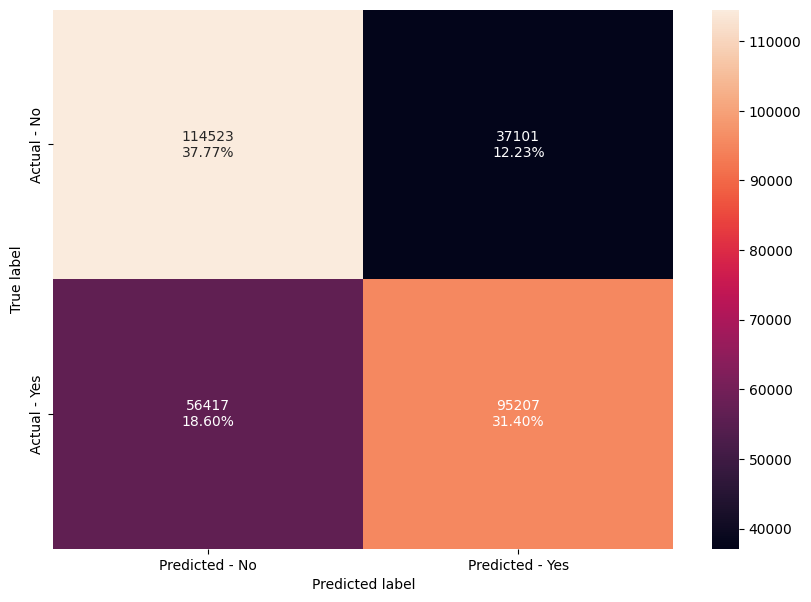

In [ ]:
# Creating confusion matrix
make_confusion_matrix(xgb_model, y_test)

# SGD Classifier


In [ ]:
%%time
from sklearn.linear_model import SGDClassifier
parameters = {'alpha':[10**x for x in range(-5, 5)],
              }
model_lr_reg = SGDClassifier(loss = "squared_loss",fit_intercept=False,l1_ratio=0.6)
model=GridSearchCV(estimator = model_lr_reg, param_grid = parameters,
                                    return_train_score=True, scoring = 'accuracy',\
                                    cv = 5,verbose=2,n_jobs=-1)
model.fit(train_s,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 29.7min finished


CPU times: user 7.5 s, sys: 1.56 s, total: 9.05 s
Wall time: 29min 43s


In [ ]:
model=SGDClassifier(alpha=0.00001)
model.fit(X_train,y_train)

SGDClassifier(alpha=1e-05, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Accuracy on training set :  0.7666857929443821
Accuracy on test set :  0.6718329552049808
Recall on training set :  0.6883537927974018
Recall on test set :  0.5827837281696829
Precision on training set :  0.8162272131598087
Precision on test set :  0.7090675653988124
log_loss on training set :  8.058449188937065
log_loss on test set :  11.334583779350103


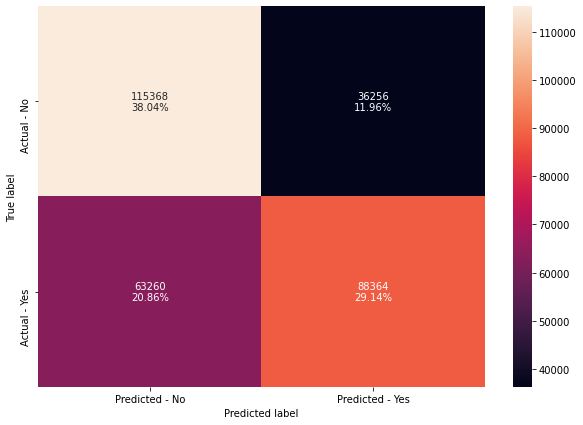

In [ ]:
get_metrics_score(model,X_train,X_test_s,y_train,y_test)

# Creating confusion matrix
make_confusion_matrix(model, y_test)

### **MLP:** ###

In [40]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [41]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42)

In [43]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vec = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_comment = vec.fit_transform(X_train['comment'])
X_test_comment = vec.transform(X_test['comment'])

CPU times: total: 31.4 s
Wall time: 31.5 s


In [44]:
print(X_train_comment.shape)

(707578, 200000)


In [45]:
%%time
vec = tfidf_desc = TfidfVectorizer(max_features=200000, ngram_range=(1, 3), stop_words='english')
X_train_parent = vec.fit_transform(X_train['parent_comment'])
X_test_parent = vec.transform(X_test['parent_comment'])
print(X_train_parent.shape)

(707578, 200000)
CPU times: total: 1min 23s
Wall time: 1min 23s


In [46]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_author = vec = tfidf_desc = TfidfVectorizer()
X_train_author = lb_brand_author.fit_transform(X_train['author'])
X_test_author = lb_brand_author.transform(X_test['author'])

CPU times: total: 4.53 s
Wall time: 4.82 s


In [47]:
%%time
from sklearn.preprocessing import LabelBinarizer
lb_brand_subreddit = LabelBinarizer(sparse_output=True)
X_train_subreddit = lb_brand_author.fit_transform(X_train['subreddit'])
X_test_subreddit = lb_brand_author.transform(X_test['subreddit'])

CPU times: total: 2.3 s
Wall time: 2.31 s


In [48]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

CPU times: total: 15.6 ms
Wall time: 33.6 ms


In [49]:
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

In [50]:
%%time
from scipy.sparse import hstack
X_train=hstack((X_train_comment,X_train_parent,X_train_author,X_train_subreddit,X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_com_len,X_train_parent_com_len)).tocsr().astype('float32')
X_test=hstack((X_test_comment,X_test_parent,X_test_author,X_test_subreddit,X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neg,X_test_pos,X_test_neu,X_test_com_len,X_test_parent_com_len)).tocsr().astype('float32')

CPU times: total: 1.58 s
Wall time: 1.62 s


In [51]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(707578, 654778) (707578, 2)
(303248, 654778) (303248, 2)


In [52]:
from tensorflow.keras import regularizers
def mlp_model(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.40)(out)
    out = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.15)(out)
    out = Dense(2,activation='softmax')(out)
    model = Model(model_in, out)
    return model

In [53]:
model1=mlp_model(X_train.shape[1])

In [ ]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 654778)]          0         
                                                                 
 dense (Dense)               (None, 512)               335246848 
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                             

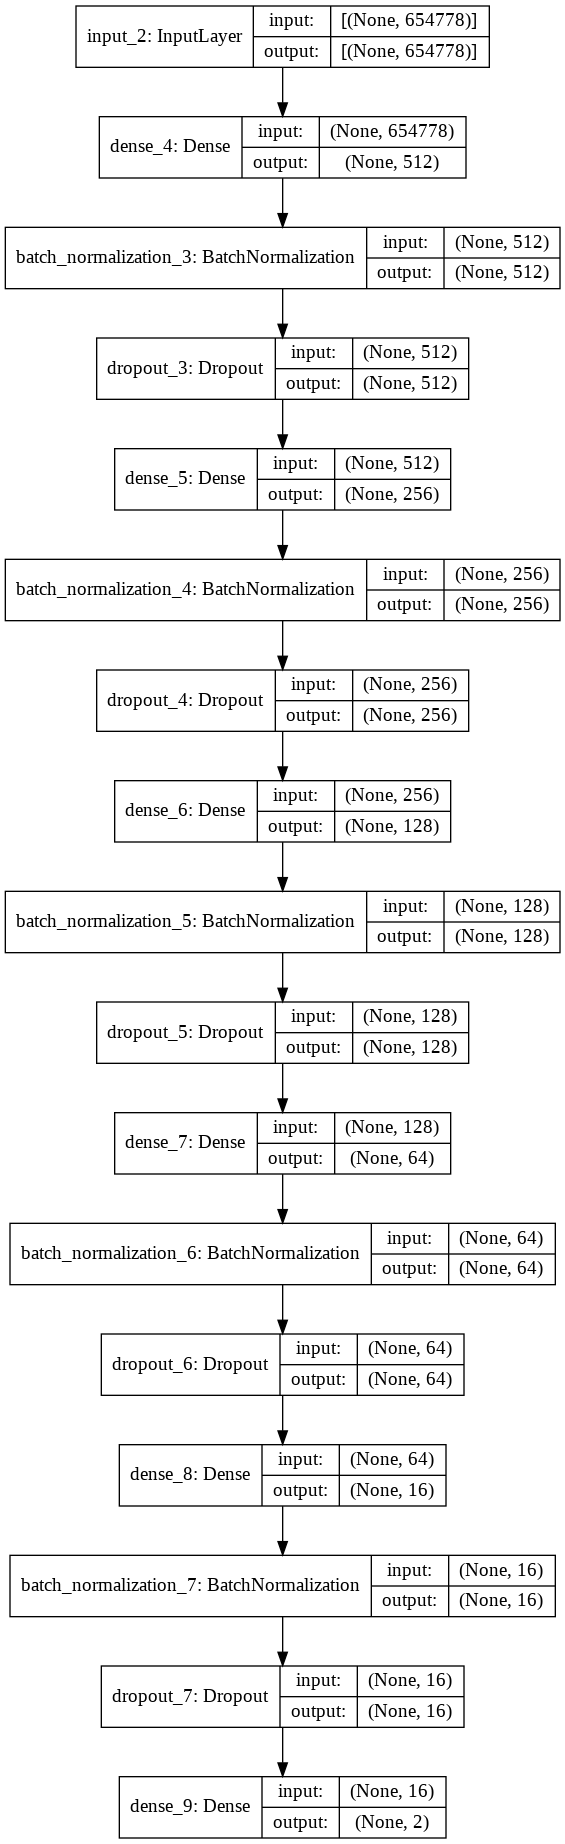

In [ ]:
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [ ]:
hitory1=model1.fit(x=X_train,y=y_train,epochs=50,batch_size=1024,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
691/691 [==============================] - 71s 101ms/step - loss: 0.5930 - accuracy: 0.9681 - val_loss: 1.6724 - val_accuracy: 0.6325

Epoch 00001: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 2/50
691/691 [==============================] - 65s 93ms/step - loss: 0.5431 - accuracy: 0.9753 - val_loss: 1.7044 - val_accuracy: 0.6344

Epoch 00002: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 3/50
691/691 [==============================] - 65s 93ms/step - loss: 0.4982 - accuracy: 0.9794 - val_loss: 1.7310 - val_accuracy: 0.6374

Epoch 00003: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 4/50
691/691 [==============================] - 65s 92ms/step - loss: 0.4575 - accuracy: 0.9822 - val_loss: 1.7477 - val_accuracy: 0.6404

Epoch 00004: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: we

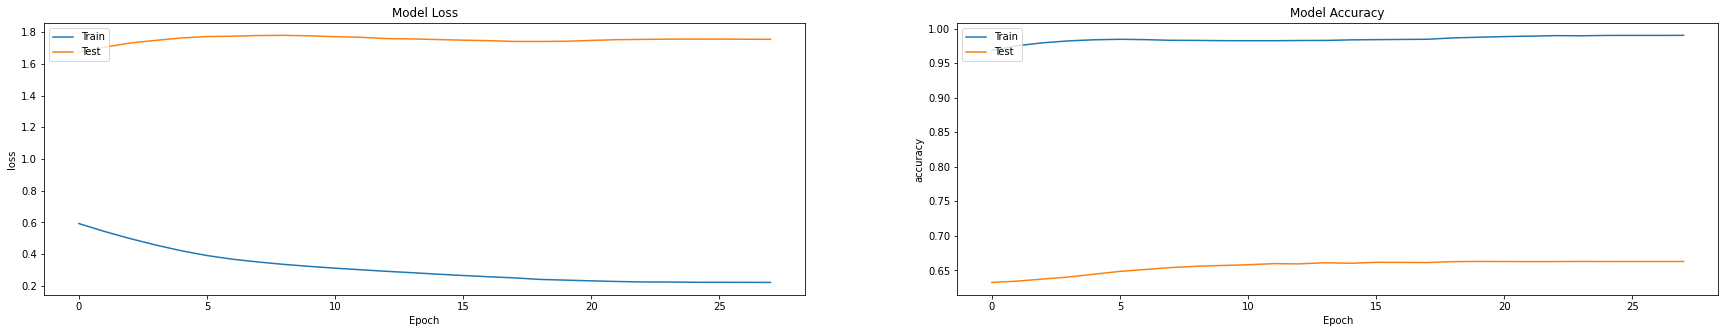

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

###  **LSTM:** ###

In [ ]:
data['comment']=data['comment']+" "+data['author']+" "+data['subreddit']

In [ ]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [ ]:
y=data['label']
X=data.drop(['label','date','created_utc'],axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,labels,test_size=0.3,random_state=42,stratify=labels)

In [ ]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    vocab=5000
    token=Tokenizer()
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [ ]:
comm_len=200
train_com_pad,test_com_pad,token_com= text_padding(X_train['comment'],X_test['comment'],comm_len)
print(train_com_pad.shape,test_com_pad.shape)
par_comm_len=200
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 200) (303248, 200)
(707578, 200) (303248, 200)


In [ ]:
def generate_embedding_matrix(token):
    embedding_path="D:\Assignment\case study 2\glove.42B.300d.txt"
    embedding_dimension=300
    embedding_index={}
    with open(embedding_path) as f:
         for line in f:
             values=line.split()
             word=values[0]
             coefs=np.asarray(values[1:],dtype='float32')
             embedding_index[word]=coefs
    f.close()        
    embedding_matrix=np.zeros((len(token.word_index)+1,embedding_dimension))
    num_words_in_embedding = 0
    for word, i in token.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
           embedding_matrix[i] = embedding_vector
        #print("embedding matrix shape",embedding_matrix.shape)
    return embedding_matrix

In [ ]:
embedding_comm = generate_embedding_matrix(token_com)
embedding_P_comm = generate_embedding_matrix(token_par)
print(embedding_comm.shape,embedding_P_comm.shape)

(362500, 300) (189737, 300)


In [ ]:
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(X_train['score'].values.reshape(-1,1))
X_test_score=trans.transform(X_test['score'].values.reshape(-1,1))

In [ ]:
X_train_ups=trans.fit_transform(X_train['ups'].values.reshape(-1,1))
X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))
X_train_downs=trans.fit_transform(X_train['downs'].values.reshape(-1,1))
X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))
X_train_comp=trans.fit_transform(X_train['compound'].values.reshape(-1,1))
X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))
X_train_neg=trans.fit_transform(X_train['negative'].values.reshape(-1,1))
X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))
X_train_pos=trans.fit_transform(X_train['positive'].values.reshape(-1,1))
X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))
X_train_neu=trans.fit_transform(X_train['neutral'].values.reshape(-1,1))
X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))
X_train_com_len=trans.fit_transform(X_train['com_len'].values.reshape(-1,1))
X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))
X_train_parent_com_len=trans.fit_transform(X_train['parent_com_len'].values.reshape(-1,1))
X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

In [ ]:
Train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
Test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)

In [ ]:
print(Train.shape,Test.shape)

(707578, 9) (303248, 9)


In [ ]:
X_train=[train_com_pad,train_par_com_pad,Train]
X_test=[test_com_pad,test_par_com_pad,Test]

Lstm:

In [ ]:
from tensorflow.keras.layers import concatenate
def LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm):
    drop_lstm = 0.25
    drop_dense = 0.25
    num_lstm=150
  
    input_text_1=Input(shape=(comm_len,), name='Comment', dtype='float32')
    sequence_input_1=Embedding(len(token_com.word_index) + 1,300,weights=[embedding_comm],input_length=comm_len,trainable=False,dtype=tf.float32)(input_text_1)
    sequence_input_1=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_1)
    sequence_input_1=Flatten()(sequence_input_1)
    
    input_text_2=Input(shape=(par_comm_len,),name='parent_comment', dtype='float32')
    sequence_input_2=Embedding(len(token_par.word_index) + 1,300,weights=[embedding_P_comm],input_length=par_comm_len,trainable=False,dtype=tf.float32)(input_text_2)
    sequence_input_2=LSTM(num_lstm,dropout=drop_lstm,return_sequences=True,dtype=tf.float32)(sequence_input_2)
    sequence_input_2=Flatten()(sequence_input_2)
    
    
    input5 = Input(shape=(9,),name='Numerical', dtype='float32')
    flatten_6 = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(input5)
    flatten_6 = Dense(16,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.0001),dtype=tf.float32)(flatten_6)
    concat=concatenate([sequence_input_1,sequence_input_2,flatten_6],dtype=tf.float32)
  
    y = Dense(128,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(concat)
    y = BatchNormalization()(y)
    y = Dense(64,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
    y = BatchNormalization()(y)
    y = Dense(32,activation='relu',kernel_initializer=he_normal(),kernel_regularizer=l2(0.01))(y)
  
    final_output=Dense(2,activation='softmax')(y)
  
    model= Model(inputs=[input_text_1,input_text_2,input5],outputs=final_output)
    return model

In [ ]:
model1=LSTM_Model1(comm_len,token_com,par_comm_len,token_par,embedding_comm,embedding_P_comm)
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Comment (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 parent_comment (InputLayer)    [(None, 200)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 200, 300)     108750000   ['Comment[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 200, 300)     56921100    ['parent_comment[0][0]']         
                                                                                            

In [ ]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_4.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [ ]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
hitory1=model1.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - ETA: 0s - loss: 1.7334 - accuracy: 0.6657
Epoch 1: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


1382/1382 [==============================] - 7593s 5s/step - loss: 1.7334 - accuracy: 0.6657 - val_loss: 2.5081 - val_accuracy: 0.5001 - lr: 0.0100
Epoch 2/50
1382/1382 [==============================] - ETA: 0s - loss: 1.1648 - accuracy: 0.7054
Epoch 2: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


1382/1382 [==============================] - 6550s 5s/step - loss: 1.1648 - accuracy: 0.7054 - val_loss: 6.4899 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/50
1382/1382 [==============================] - ETA: 0s - loss: 1.0259 - accuracy: 0.7141
Epoch 3: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets



Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
1382/1382 [==============================] - 7699s 6s/step - loss: 1.0259 - accuracy: 0.7141 - val_loss: 3.4706 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/50
1382/1382 [==============================] - ETA: 0s - loss: 0.5993 - accuracy: 0.7289
Epoch 4: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


1382/1382 [==============================] - 7367s 5s/step - loss: 0.5993 - accuracy: 0.7289 - val_loss: 0.6645 - val_accuracy: 0.6819 - lr: 0.0025
Epoch 5/50
1382/1382 [==============================] - ETA: 0s - loss: 0.5943 - accuracy: 0.7342
Epoch 5: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


1382/1382 [==============================] - 8646s 6s/step - loss: 0.5943 - accuracy: 0.7342 - val_loss: 2.7898 - val_accuracy: 0.5000 - lr: 0.0025
Epoch 6/50
1382/1382 [==============================] - ETA: 0s - loss: 0.5772 - accuracy: 0.7375
Epoch 6: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets



Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
1382/1382 [==============================] - 7167s 5s/step - loss: 0.5772 - accuracy: 0.7375 - val_loss: 1.1346 - val_accuracy: 0.5436 - lr: 0.0025
Epoch 7/50
1382/1382 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.7447
Epoch 7: saving model to weights_4.best.hdf1


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


INFO:tensorflow:Assets written to: weights_4.best.hdf1\assets


1382/1382 [==============================] - 7532s 5s/step - loss: 0.5236 - accuracy: 0.7447 - val_loss: 1.8970 - val_accuracy: 0.5000 - lr: 6.2500e-04
Epoch 7: early stopping


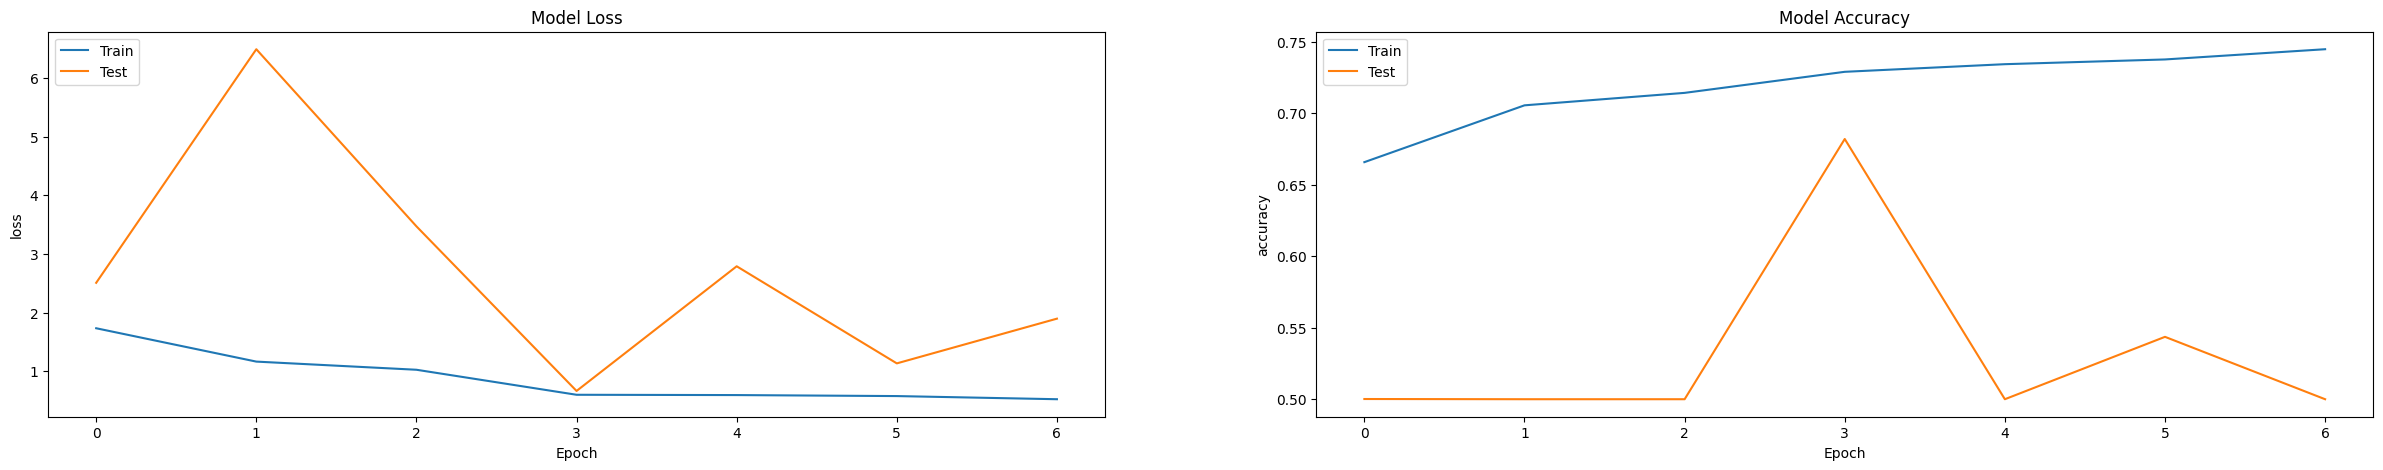

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### **Bert:** ###

In [67]:
data['comment']=data['comment']+" "+data['author']+" "+data['parent_comment']+" "+data['subreddit']

In [68]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|█████████████████████████████████████████████████████████████████████| 1010826/1010826 [00:46<00:00, 21906.81it/s]


In [69]:
X_train, X_test, y_train, y_test = train_test_split(data['comment'],data['label'], stratify=data['label'])

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [10]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [11]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [70]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [71]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
out = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
out = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(out)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [out])

In [72]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_1 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [73]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [74]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_bert.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [ ]:
hitory=model.fit(x=X_train,y=y_train,epochs=50,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
16932/23692 [====================>.........] - ETA: 14:18:17 - loss: 0.6764 - accuracy: 0.5779

### **CNN:** ###

In [ ]:
def pad_text(text,tokenizer,max_len):
    return pad_sequences(tokenizer.texts_to_sequences(text),maxlen=max_len,padding='post')

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
def text_padding(train,test,max_len):
    token=Tokenizer(num_words = max_len,oov_token='OOV')
    token.fit_on_texts(train)
    padded_train_text=pad_text(train,token,max_len)
    padded_test_text=pad_text(test,token,max_len)
    return padded_train_text,padded_test_text,token

In [ ]:
par_comm_len=500
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)

In [ ]:
par_comm_len=500
train_par_com_pad,test_par_com_pad,token_par= text_padding(X_train['parent_comment'],X_test['parent_comment'],par_comm_len)

In [ ]:
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 500) (303248, 500)


In [ ]:
print(train_par_com_pad.shape,test_par_com_pad.shape)

(707578, 500) (303248, 500)


In [ ]:
numerical_train=np.concatenate((X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neu,X_train_neg,X_train_pos,X_train_com_len,X_train_parent_com_len),axis=1)
numerical_test=np.concatenate((X_test_score,X_test_ups,X_test_downs,X_test_comp,X_test_neu,X_test_neg,X_test_pos,X_test_com_len,X_test_parent_com_len),axis=1)

In [ ]:
print(numerical_train.shape,numerical_test.shape)

(707578, 9) (303248, 9)


In [ ]:
X_train=[train_com_pad,train_par_com_pad,numerical_train]
X_test=[test_com_pad,test_par_com_pad,numerical_test]

In [ ]:
def Deep_CNN1D2():
    input_1 = Input(shape=(500,),name = 'input_comment')
    embedding_layer_1 = Embedding(input_dim = 500,output_dim = 100,input_length = 500)(input_1)
    conv_1_1 = Conv1D(32,3,strides=2, padding='same',activation='relu')(embedding_layer_1)
    conv_1_2 = Conv1D(16,3, strides=2, padding='same',activation='relu')(embedding_layer_1)
    conv_1_3 = Conv1D(8,3, strides=2, padding='same',activation='relu')(embedding_layer_1)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, conv_1_2, conv_1_3])
    pool_1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_1)
    conv_2_1 = keras.layers.Conv1D(8,7, strides=2, padding='same',activation='relu')(pool_1)
    conv_2_2 = keras.layers.Conv1D(16,5, strides=2, padding='same',activation='relu')(pool_1) 
    conv_2_3 = keras.layers.Conv1D(32,3, strides=2, padding='same',activation='relu')(pool_1)
    concate_2 = keras.layers.Concatenate(axis=-1)([conv_2_1, conv_2_2, conv_2_3])
    pool_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_2)
    conv_3 = Conv1D(20,3,strides=2, padding='same')(pool_2)
    flatten_1 = Flatten()(conv_3)

    # creating layers for parent comment data
    input_2 = Input(shape=(200,),name = 'input_parent_comment')
    embedding_layer_2 = Embedding(input_dim = 500,output_dim = 100,input_length = 200)(input_2)
    conv_1_1 = Conv1D(32,3,strides=2, padding='same',activation='relu')(embedding_layer_2)
    conv_1_2 = Conv1D(16,3, strides=2, padding='same',activation='relu')(embedding_layer_2)
    conv_1_3 = Conv1D(8,3, strides=2, padding='same',activation='relu')(embedding_layer_2)
    concate_1 = keras.layers.Concatenate(axis=-1)([conv_1_1, conv_1_2, conv_1_3])
    pool_1 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_1)
    conv_2_1 = keras.layers.Conv1D(8,7, strides=2, padding='same',activation='relu')(pool_1)
    conv_2_2 = keras.layers.Conv1D(16,5, strides=2, padding='same',activation='relu')(pool_1) 
    conv_2_3 = keras.layers.Conv1D(32,3, strides=2, padding='same',activation='relu')(pool_1)
    concate_2 = keras.layers.Concatenate(axis=-1)([conv_2_1, conv_2_2, conv_2_3])
    pool_2 = keras.layers.MaxPooling1D(pool_size=2, strides=2, padding='same')(concate_2)
    conv_131 = Conv1D(20,3,strides=2, padding='same')(pool_2)
    flatten_2 = Flatten()(conv_131)

    # creating layers for numerical columns
    input_3 = Input(shape=(9,), name = "input_numerical")
    dense_num_layer = Dense(128, activation = "relu")(input_3)

    concatenated_layer = keras.layers.concatenate([flatten_1,flatten_2,dense_num_layer],axis=-1)

    # creating further layers
    x = Dense(128, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(concatenated_layer)
    x = BatchNormalization()(x)
    x = Dense(64, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation = 'relu',kernel_initializer=glorot_uniform(seed=42))(x)
    output = Dense(2, activation = 'softmax', name= 'model_output',kernel_initializer=glorot_uniform(seed=42))(x)
    model = Model(inputs = [input_1,input_2,input_3], outputs = [output])
    return model

In [ ]:
model1=Deep_CNN1D2()
model1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_comment (InputLayer)      [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_parent_comment (InputLaye [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 500, 100)     50000       input_comment[0][0]              
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 200, 100)     50000       input_parent_comment[0][0]       
____________________________________________________________________________________________

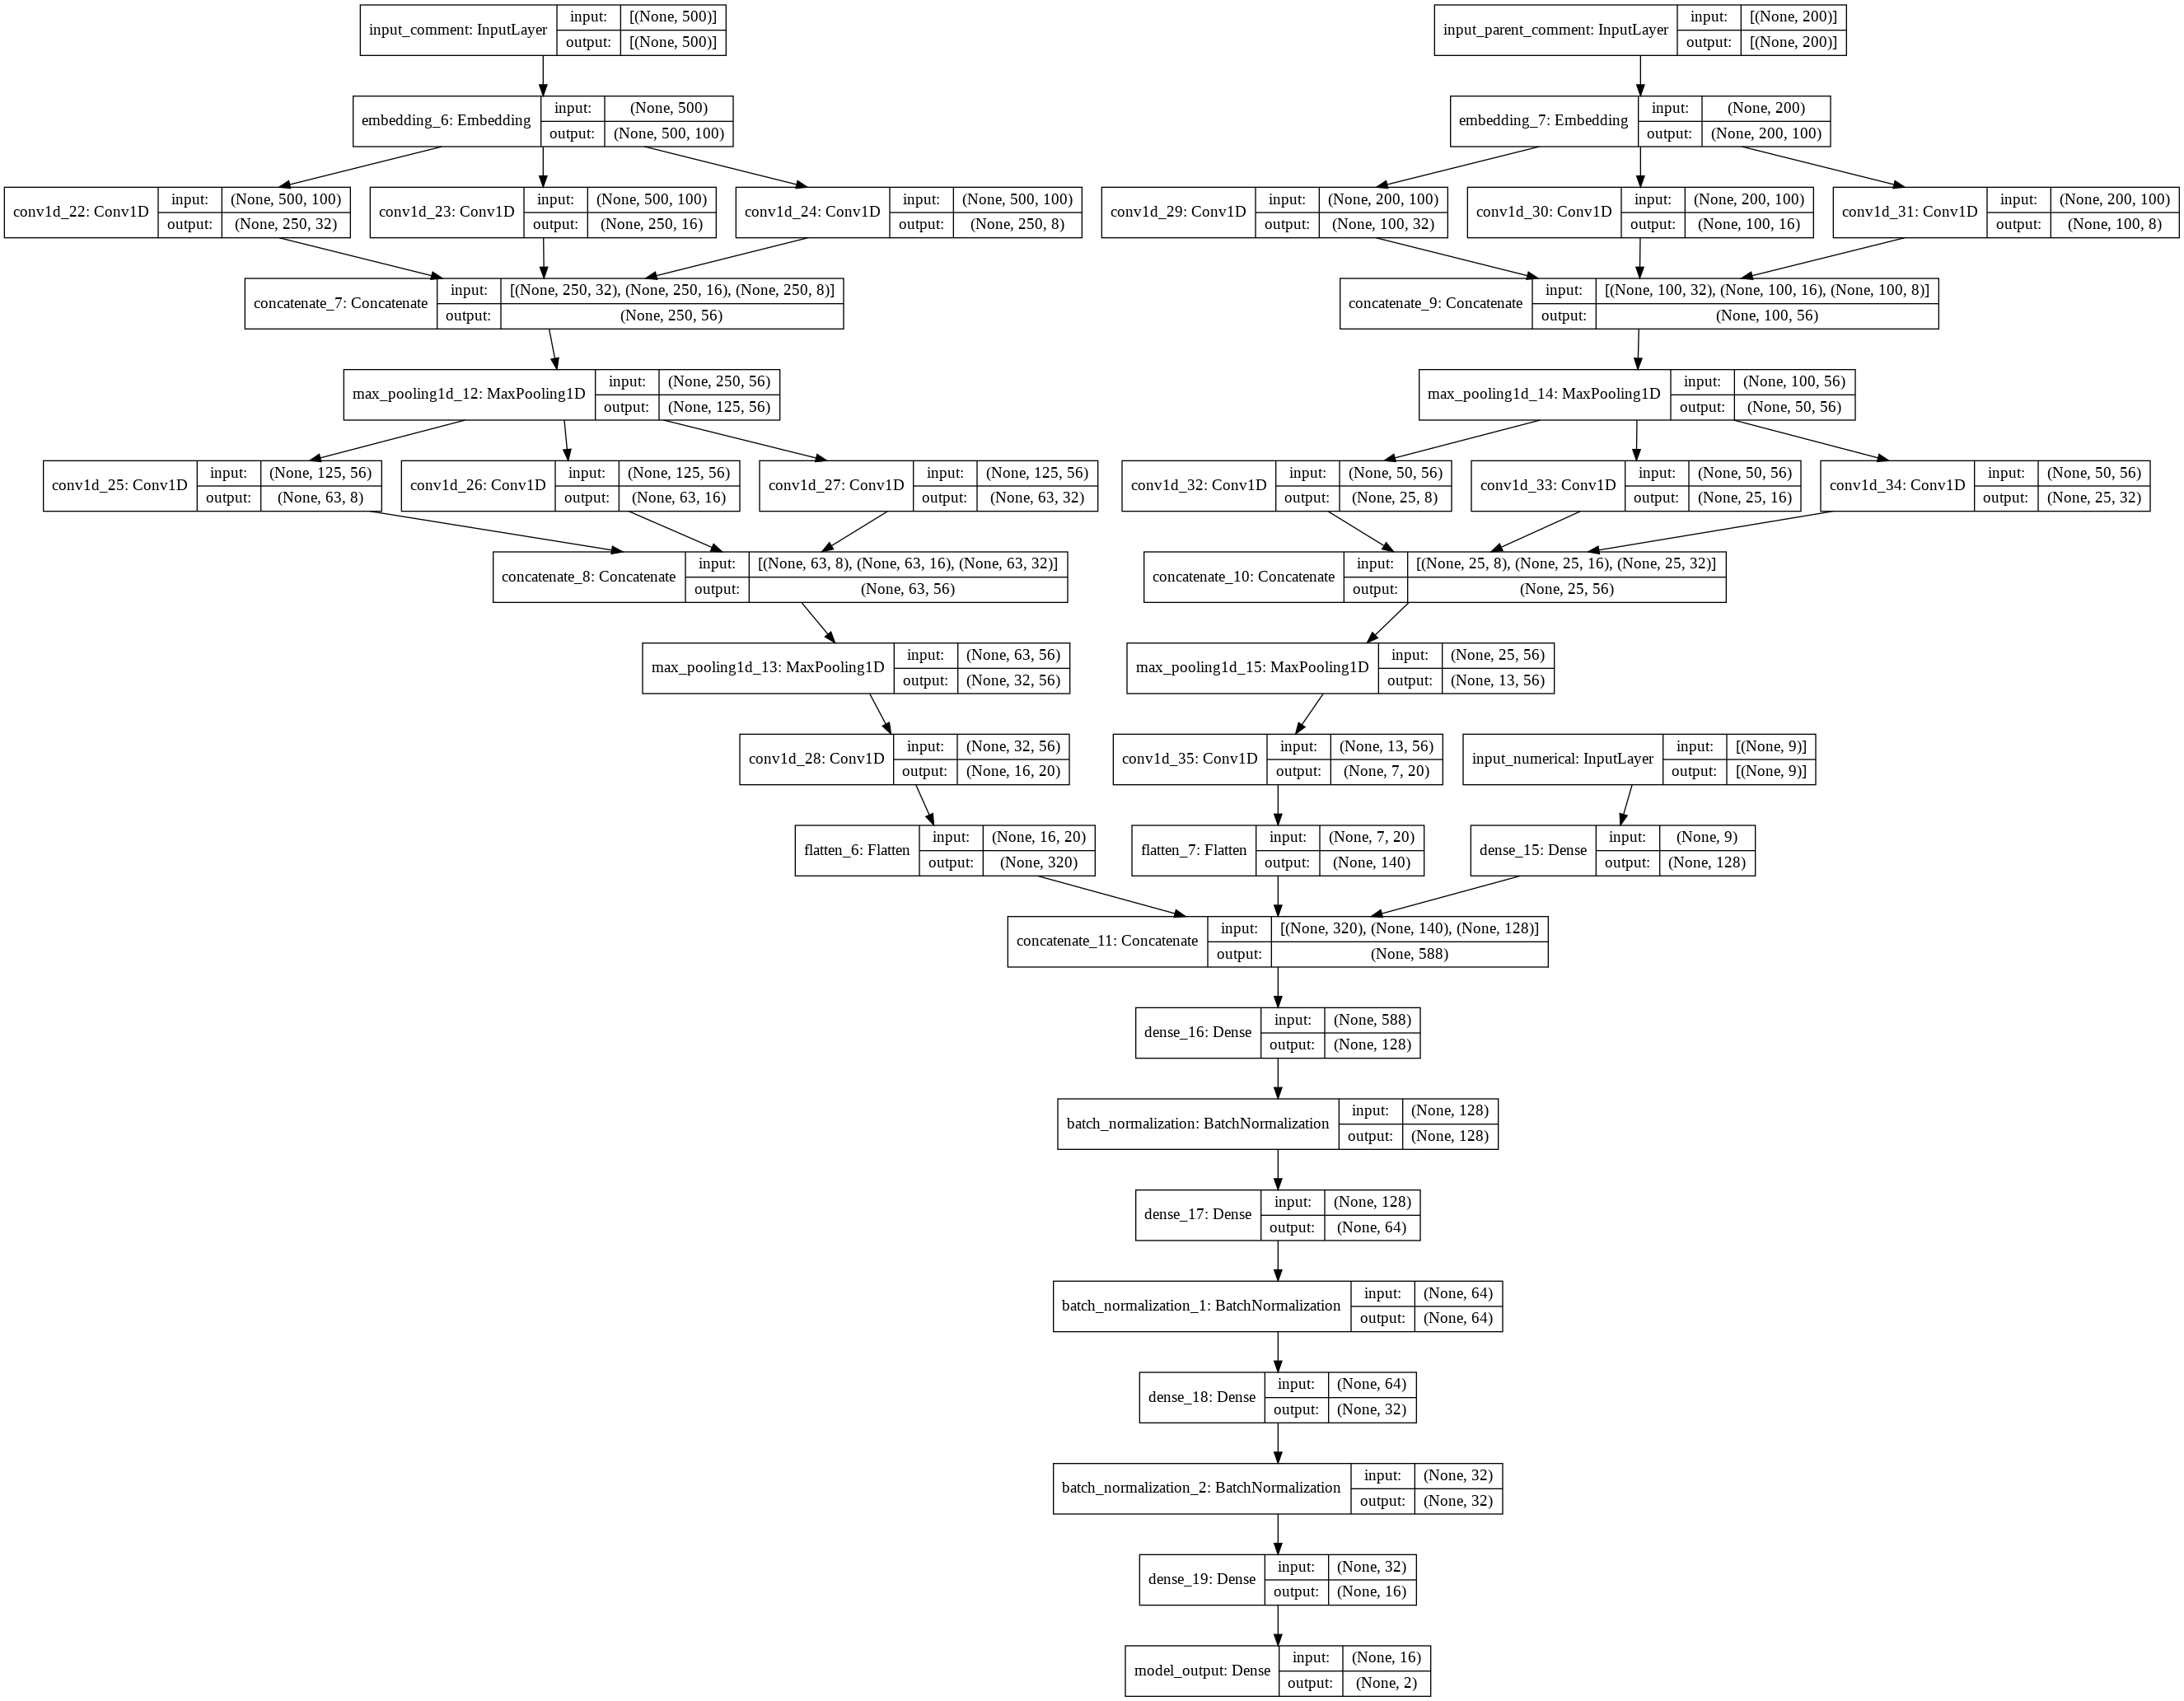

In [ ]:
tf.keras.utils.plot_model(
    model1, to_file='model1.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_11.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 3,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_11", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [ ]:
hitory1=model1.fit(x=X_train,y=y_train,epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/50
1382/1382 [==============================] - 131s 93ms/step - loss: 0.6185 - accuracy: 0.6488 - val_loss: 0.5877 - val_accuracy: 0.6839

Epoch 00001: saving model to weights_11.best.hdf1
INFO:tensorflow:Assets written to: weights_11.best.hdf1/assets
Epoch 2/50
1382/1382 [==============================] - 138s 100ms/step - loss: 0.5773 - accuracy: 0.6925 - val_loss: 0.5792 - val_accuracy: 0.6899

Epoch 00002: saving model to weights_11.best.hdf1
INFO:tensorflow:Assets written to: weights_11.best.hdf1/assets
Epoch 3/50
1382/1382 [==============================] - 138s 100ms/step - loss: 0.5669 - accuracy: 0.7010 - val_loss: 0.5735 - val_accuracy: 0.6956

Epoch 00003: saving model to weights_11.best.hdf1
INFO:tensorflow:Assets written to: weights_11.best.hdf1/assets
Epoch 4/50
1382/1382 [==============================] - 137s 99ms/step - loss: 0.5590 - accuracy: 0.7073 - val_loss: 0.5758 - val_accuracy: 0.6946

Epoch 00004: saving model to weights_11.best.hdf1
INFO:tensorflow:A

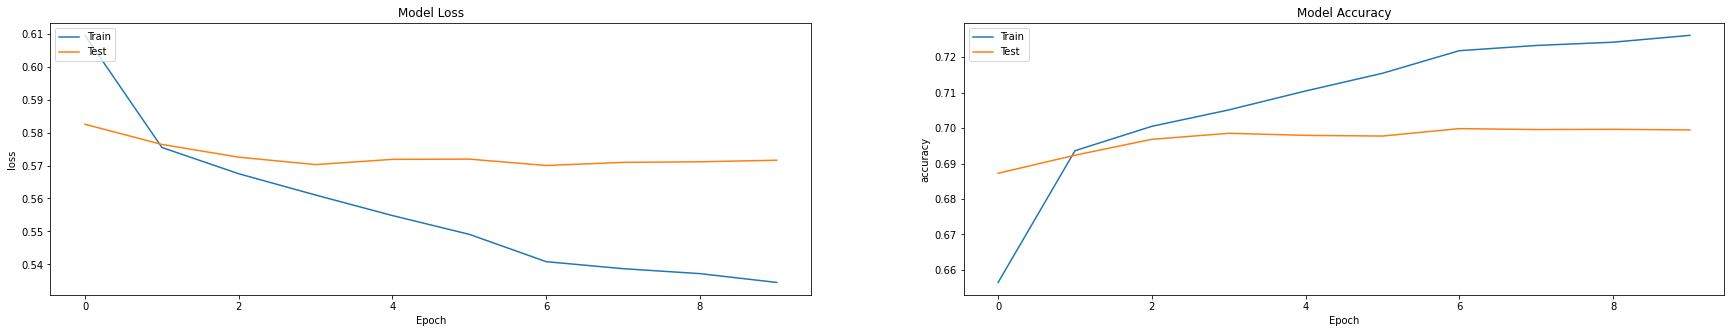

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### **Summary** ###

In [ ]:
from tabulate import tabulate

Accuracies= [['model', 'Train accuracy', 'Test accuracy'],
            ['Logistic Regression', 0.70, 0.67],
            ['XGBoost', 0.76, 0.69],
            ['SGD Classifier', 0.76, 0.67],
            ['MLP', 0.96, 0.67],
            ['LSTM', 0.76, 0.68],
            ['CNN', 0.73, 0.69]]

print(tabulate(Accuracies, headers='firstrow', tablefmt="grid"))